In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn tensorflow keras imbalanced-learn


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/Job_task/data/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Job_task/data/validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Job_task/data/test.csv')





In [45]:
train_df.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


In [46]:
val_df.head()

,id,feedback_text,lang,toxic
0,1203,İyi tamam olabilir. Balkanlar maddesini gelişt...,tr,0
1,5871,"Por dios, y la canción de John Lennon: http://...",es,1
2,3590,Selam. Öncelikle tebrik ederim... Bu arada ken...,tr,0
3,447,Leggiti tutte le discussioni. Magari cancellal...,it,1
4,6634,A LAS TOKITAS NOS VALE QUE LAS JONATICAS INSUL...,es,1


In [8]:
test_df.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [9]:
# dataset info
train_df.info()
val_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23473 entries, 0 to 23472
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             23473 non-null  object
 1   feedback_text  23473 non-null  object
 2   toxic          23473 non-null  int64 
 3   abusive        23473 non-null  int64 
 4   vulgar         23473 non-null  int64 
 5   menace         23473 non-null  int64 
 6   offense        23473 non-null  int64 
 7   bigotry        23473 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             840 non-null    int64 
 1   feedback_text  840 non-null    object
 2   lang           840 non-null    object
 3   toxic          840 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 26.4+ KB

In [10]:
#check for missing values
def checking_m(train_df):
    null_v = train_df.isnull().sum().sort_values(ascending=False)
    null_percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(train_df)

,Missing_Number,Missing_Percent
id,0,0.0
feedback_text,0,0.0
toxic,0,0.0
abusive,0,0.0
vulgar,0,0.0
menace,0,0.0
offense,0,0.0
bigotry,0,0.0


In [11]:
#check for missing values
def checking_m(test_df):
    null_v = test_df.isnull().sum().sort_values(ascending=False)
    null_percent = (test_df.isnull().sum()/test_df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(test_df)

,Missing_Number,Missing_Percent
id,0,0.0
content,0,0.0
lang,0,0.0


In [12]:
#check for missing values
def checking_m(val_df):
    null_v = val_df.isnull().sum().sort_values(ascending=False)
    null_percent = (val_df.isnull().sum()/val_df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(val_df)

,Missing_Number,Missing_Percent
id,0,0.0
feedback_text,0,0.0
lang,0,0.0
toxic,0,0.0


In [47]:
train_df.toxic.value_counts()

,count
toxic,
0,21277
1,2196


In [13]:
# Define label columns and text column
LABEL_COLUMNS = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
TEXT_COLUMN = 'feedback_text'

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_multiple_countplots(train_df, columns, figsize=(12, 5)):

    n = len(columns)
    fig, axes = plt.subplots(1, n, figsize=figsize)

    for i, col in enumerate(columns):
        sns.countplot(data=train_df, x=col, ax=axes[i])
        axes[i].set_title(f'Count Plot for {col}')
        axes[i].set_xlabel('Category')
        axes[i].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


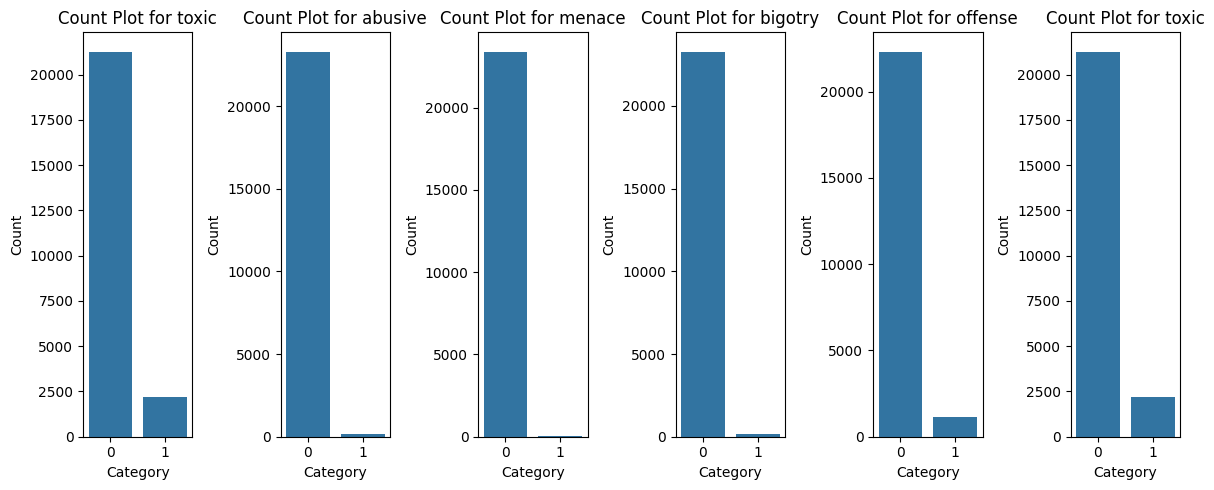

In [15]:
plot_multiple_countplots(train_df, ['toxic','abusive','menace','bigotry', 'offense','toxic'])

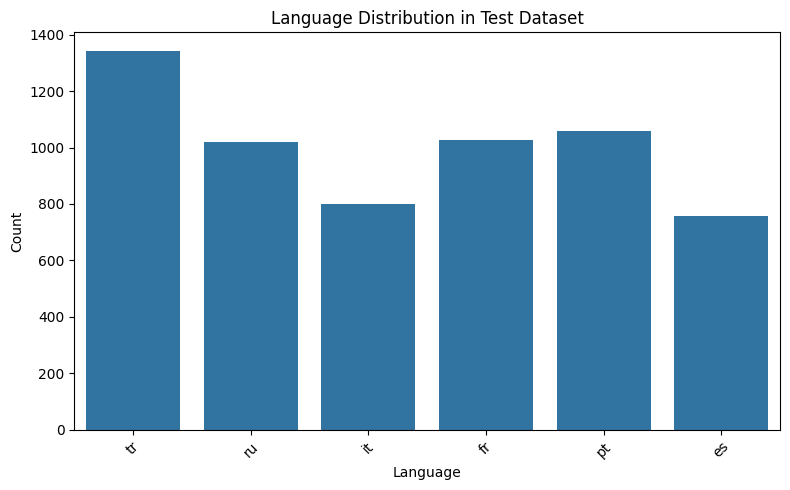

In [16]:

def plot_language_distribution(test_df, figsize=(8, 5)):

    plt.figure(figsize=figsize)
    sns.countplot(data=test_df, x='lang')
    plt.title('Language Distribution in Test Dataset')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to plot the language distribution
plot_language_distribution(test_df)

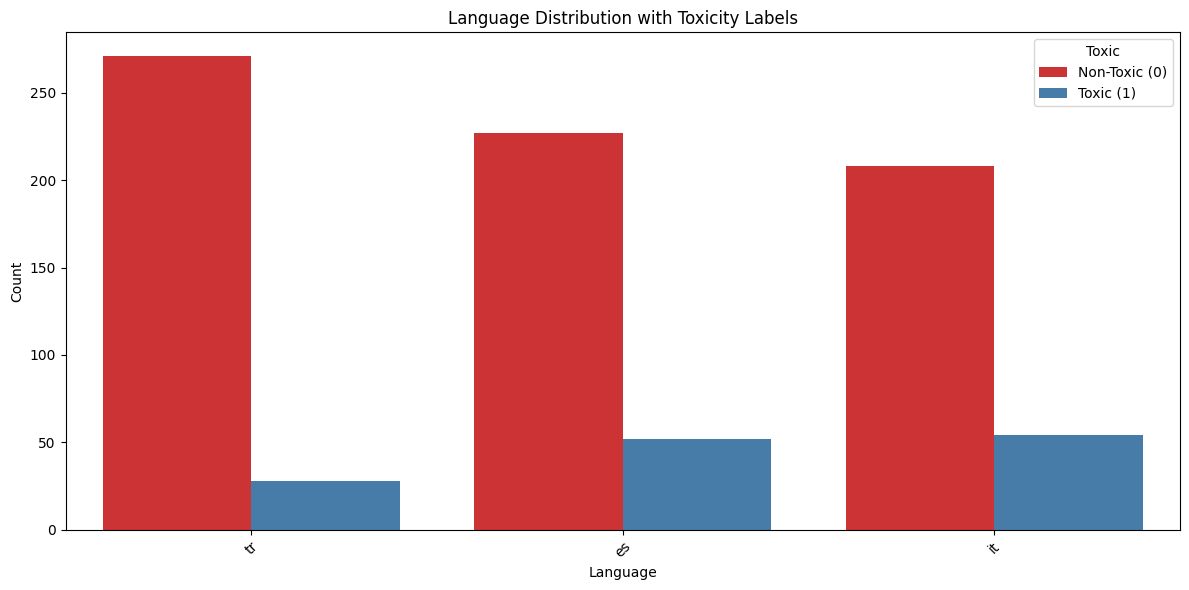

In [17]:
def plot_lang_toxic_distribution(val_df, lang_col='lang', toxic_col='toxic', figsize=(12, 6)):

    plt.figure(figsize=figsize)

    # Create a count plot for 'lang' with hue based on 'toxic'
    sns.countplot(data=val_df, x=lang_col, hue=toxic_col, palette='Set1')

    plt.title('Language Distribution with Toxicity Labels')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.legend(title='Toxic', loc='upper right', labels=['Non-Toxic (0)', 'Toxic (1)'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to plot the distribution
plot_lang_toxic_distribution(val_df)



 Checking Missing Values...
Missing values per column:

id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
dtype: int64

 Plotting Label Distributions...


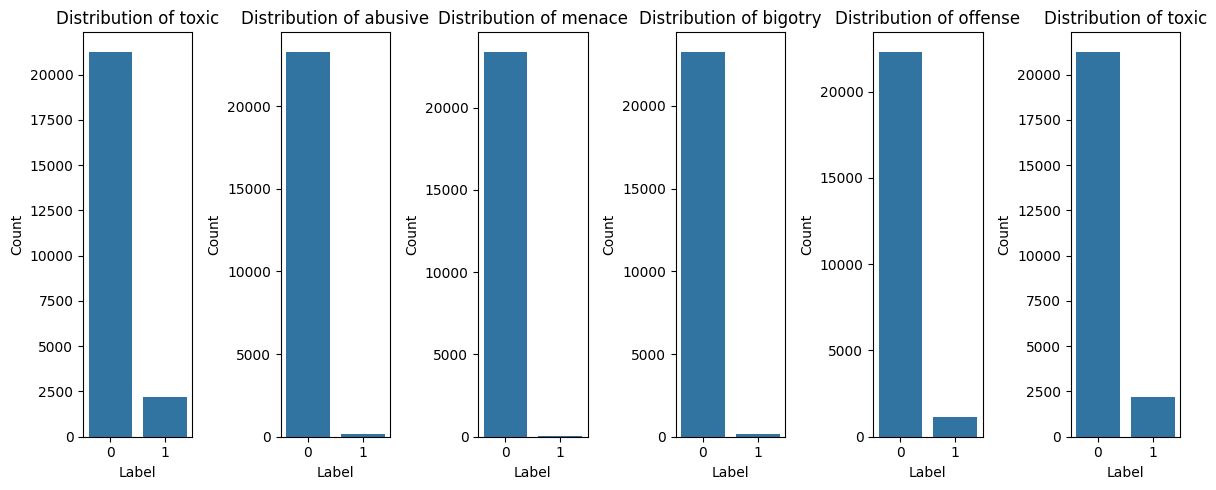


 Analyzing Sentence Structure...


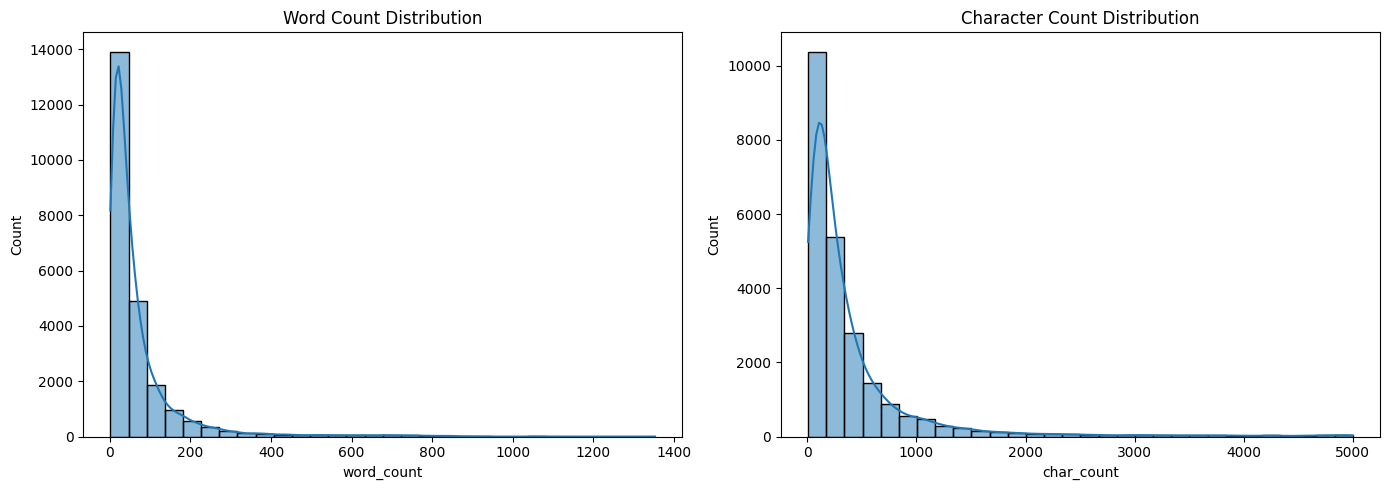


 Most Common Words in the Dataset...


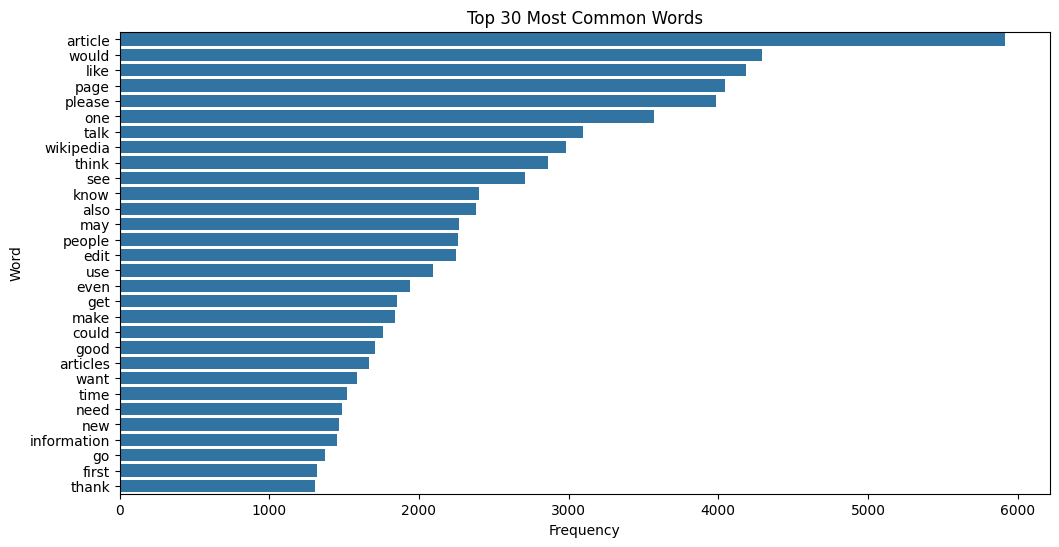

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords

text_column = "feedback_text"  # name of the text column
label_columns = ['toxic', 'abusive', 'menace', 'bigotry', 'offense', 'toxic']

# 1. Label Distribution
# -------------------------------
def plot_label_distribution(train_df, labels):
    plt.figure(figsize=(12, 5))
    for i, col in enumerate(labels):
        plt.subplot(1, len(labels), i + 1)
        sns.countplot(data=train_df, x=col)
        plt.title(f'Distribution of {col}')
        plt.xlabel('Label')
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# 2. Sentence Length Analysis
# -------------------------------
def sentence_length_analysis(train_df, text_col):
    train_df['word_count'] = train_df[text_col].apply(lambda x: len(str(x).split()))
    train_df['char_count'] = train_df[text_col].apply(lambda x: len(str(x)))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(train_df['word_count'], kde=True, bins=30, ax=axes[0])
    axes[0].set_title("Word Count Distribution")

    sns.histplot(train_df['char_count'], kde=True, bins=30, ax=axes[1])
    axes[1].set_title("Character Count Distribution")

    plt.tight_layout()
    plt.show()

# 3. Most Common Words
# -------------------------------
def plot_common_words(train_df, text_col, top_n=30):
    stop_words = set(stopwords.words('english'))
    words = " ".join(train_df[text_col]).lower().split()
    filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
    word_freq = Counter(filtered_words)
    common_words = word_freq.most_common(top_n)

    common_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    plt.figure(figsize=(12, 6))
    sns.barplot(data=common_df, y='Word', x='Frequency')
    plt.title(f"Top {top_n} Most Common Words")
    plt.show()

# 4. Missing Values
# -------------------------------
def check_missing_values(train_df):
    print("Missing values per column:\n")
    print(train_df.isnull().sum())

# 5. Run All EDA
# -------------------------------
def run_full_eda(train_df, text_col, label_cols):
    print(" Checking Missing Values...")
    check_missing_values(train_df)

    print("\n Plotting Label Distributions...")
    plot_label_distribution(train_df, label_cols)

    print("\n Analyzing Sentence Structure...")
    sentence_length_analysis(train_df, text_col)

    print("\n Most Common Words in the Dataset...")
    plot_common_words(train_df, text_col)

# Call the full EDA function
run_full_eda(train_df, text_column, label_columns)


**For Validation datadet**

In [19]:
def sentence_length_analysis(val_df, text_col):
    val_df['word_count'] = val_df[text_col].apply(lambda x: len(str(x).split()))
    val_df['char_count'] = val_df[text_col].apply(lambda x: len(str(x)))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(val_df['word_count'], kde=True, bins=30, ax=axes[0])
    axes[0].set_title("Word Count Distribution")

    sns.histplot(val_df['char_count'], kde=True, bins=30, ax=axes[1])
    axes[1].set_title("Character Count Distribution")

    plt.tight_layout()
    plt.show()

# 3. Most Common Words
# -------------------------------
def plot_common_words(val_df, text_col, top_n=30):
    stop_words = set(stopwords.words('english'))
    words = " ".join(val_df[text_col]).lower().split()
    filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
    word_freq = Counter(filtered_words)
    common_words = word_freq.most_common(top_n)

    common_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    plt.figure(figsize=(12, 6))
    sns.barplot(data=common_df, y='Word', x='Frequency')
    plt.title(f"Top {top_n} Most Common Words")
    plt.show()


 Analyzing Sentence Structure...


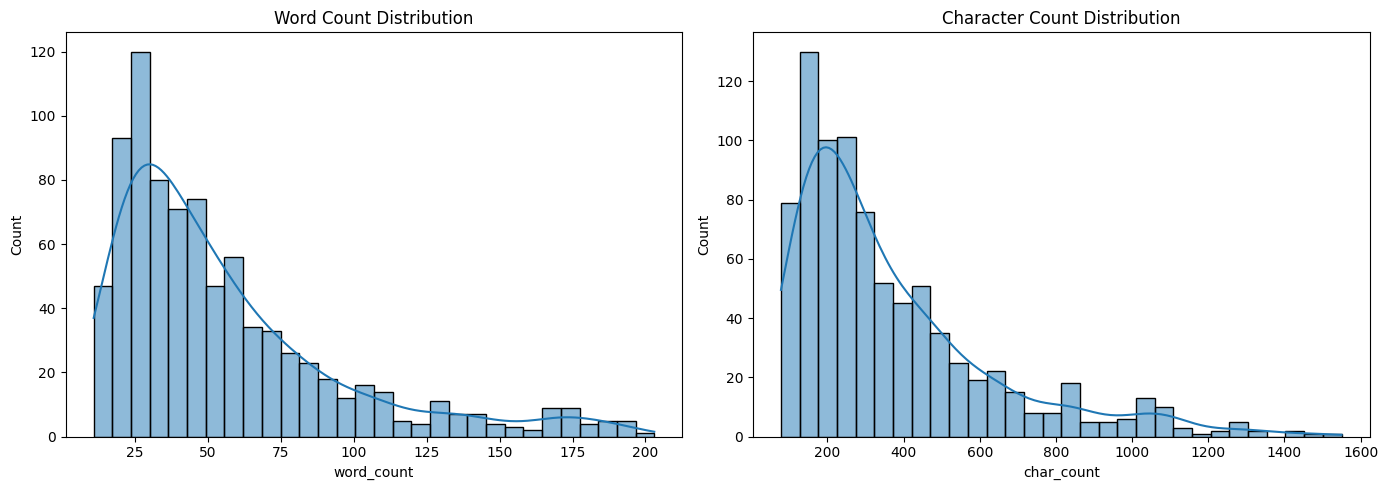


 Most Common Words in the Dataset...


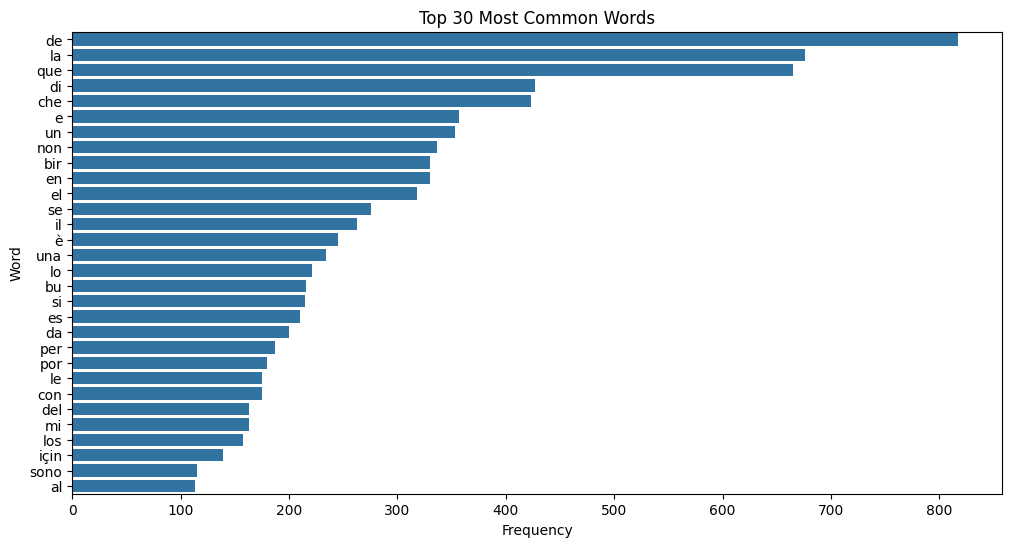

In [20]:
def run_full_eda(val_df, text_col):


    print("\n Analyzing Sentence Structure...")
    sentence_length_analysis(val_df, text_col)

    print("\n Most Common Words in the Dataset...")
    plot_common_words(val_df, text_col)

# Call the full EDA function
run_full_eda(val_df, text_column)


In [21]:
stopwords = set(stopwords.words('english'))

# Function to remove stopwords from a given text
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return " ".join(no_stopword_text)

# Function to clean the text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Expand contractions and handle common replacements
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)


    text = re.sub('\W', ' ', text)

    text = re.sub('\s+', ' ', text)

    text = text.strip(' ')

    return text

# Initialize the Snowball stemmer for English
stemmer = SnowballStemmer('english')


def stemming(sentence):
    stemmed_sentence = ""

    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "

    stemmed_sentence = stemmed_sentence.strip()

    return stemmed_sentence


In [22]:
# Clean the text data
train_df[TEXT_COLUMN] = train_df[TEXT_COLUMN].apply(clean_text)
val_df[TEXT_COLUMN] = val_df[TEXT_COLUMN].apply(clean_text)
test_df['content'] = test_df['content'].apply(clean_text)


In [23]:
train_df.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry,word_count,char_count
0,281d77b7bebc2201,sounds good let me know when you are done and ...,0,0,0,0,0,0,13,68
1,716aac7bf3c63db1,i say something but it did not actually confir...,0,0,0,0,0,0,85,413
2,57cb318c6edcf10c,agustina barrientos modelo de piñeiro juán cru...,0,0,0,0,0,0,22,173
3,dc3bd70118d91b3a,fyi i enjoy licking strangers scrotal sacks es...,1,0,1,0,0,0,10,73
4,cf10d41f2997d233,how do you get a site many penguins have asked...,0,0,0,0,0,0,88,432


In [24]:
val_df.head()

,id,feedback_text,lang,toxic,word_count,char_count
0,1203,i yi tamam olabilir balkanlar maddesini gelişt...,tr,0,58,458
1,5871,por dios y la canción de john lennon http www ...,es,1,31,235
2,3590,selam öncelikle tebrik ederim bu arada kendin ...,tr,0,27,189
3,447,leggiti tutte le discussioni magari cancellale...,it,1,31,200
4,6634,a las tokitas nos vale que las jonaticas insul...,es,1,43,229


In [25]:
test_df.head()

,id,content,lang
0,0,doctor who adlı viki başlığına 12 doctor olara...,tr
1,1,вполне возможно но я пока не вижу необходимост...,ru
2,2,quindi tu sei uno di quelli conservativi che p...,it
3,3,malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,resim seldabagcan jpg resminde kaynak sorunu r...,tr


In [26]:
train_df[TEXT_COLUMN] = train_df[TEXT_COLUMN].apply(stemming)
val_df[TEXT_COLUMN] = val_df[TEXT_COLUMN].apply(stemming)
test_df['content'] = test_df['content'].apply(stemming)

In [27]:
train_df.head()


,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry,word_count,char_count
0,281d77b7bebc2201,sound good let me know when you are done and i...,0,0,0,0,0,0,13,68
1,716aac7bf3c63db1,i say someth but it did not actual confirm any...,0,0,0,0,0,0,85,413
2,57cb318c6edcf10c,agustina barriento modelo de piñeiro juán cruz...,0,0,0,0,0,0,22,173
3,dc3bd70118d91b3a,fyi i enjoy lick stranger scrotal sack especi ...,1,0,1,0,0,0,10,73
4,cf10d41f2997d233,how do you get a site mani penguin have ask th...,0,0,0,0,0,0,88,432


In [28]:
test_df.head()


,id,content,lang
0,0,doctor who adlı viki başlığına 12 doctor olara...,tr
1,1,вполне возможно но я пока не вижу необходимост...,ru
2,2,quindi tu sei uno di quelli conservativi che p...,it
3,3,malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,resim seldabagcan jpg resmind kaynak sorunu re...,tr


In [29]:
val_df.head()

,id,feedback_text,lang,toxic,word_count,char_count
0,1203,i yi tamam olabilir balkanlar maddesini gelişt...,tr,0,58,458
1,5871,por dio y la canción de john lennon http www y...,es,1,31,235
2,3590,selam öncelikl tebrik ederim bu arada kendin a...,tr,0,27,189
3,447,leggiti tutt le discussioni magari cancellal e...,it,1,31,200
4,6634,a las tokita nos vale que las jonatica insulte...,es,1,43,229


In [30]:
train_df=train_df[['feedback_text',	'toxic',	'abusive',	'vulgar',	'menace',	'offense',	'bigotry'	]]
print(train_df.shape)

(23473, 7)


In [31]:
val_df=val_df[['feedback_text','lang','toxic']]
print(val_df.shape)

(840, 3)


In [32]:
test_df=test_df[['content',	'lang']]
print(test_df.shape)

(6000, 2)


# Baseline Model: Logistic Regression or Random Forest

---




In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Then use it like this
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df[TEXT_COLUMN])
X_val_tfidf = tfidf.transform(val_df[TEXT_COLUMN])
X_test_tfidf = tfidf.transform(test_df['content'])


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       706
           1       0.00      0.00      0.00       134

    accuracy                           0.84       840
   macro avg       0.42      0.50      0.46       840
weighted avg       0.71      0.84      0.77       840

AUC-ROC: 0.6365217115555367


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


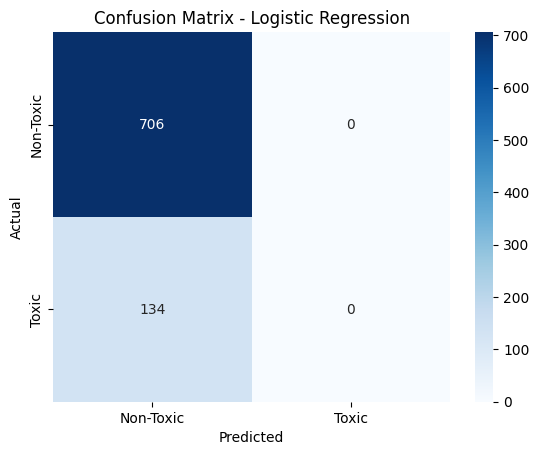

In [34]:
# Train Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, train_df['toxic'])

# Evaluate Logistic Regression
y_pred_lr = lr_model.predict(X_val_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_val_tfidf)[:, 1]

print("Logistic Regression Classification Report:")
print(classification_report(val_df['toxic'], y_pred_lr))
print("AUC-ROC:", roc_auc_score(val_df['toxic'], y_pred_proba_lr))

# Plot confusion matrix
conf_matrix_lr = confusion_matrix(val_df['toxic'], y_pred_lr)
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       706
           1       1.00      0.01      0.01       134

    accuracy                           0.84       840
   macro avg       0.92      0.50      0.46       840
weighted avg       0.87      0.84      0.77       840

AUC-ROC: 0.5923428184854763


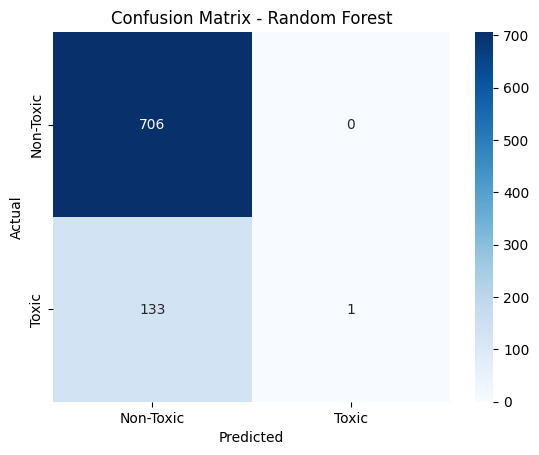

In [35]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, train_df['toxic'])

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_val_tfidf)
y_pred_proba_rf = rf_model.predict_proba(X_val_tfidf)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(val_df['toxic'], y_pred_rf))
print("AUC-ROC:", roc_auc_score(val_df['toxic'], y_pred_proba_rf))

# Plot confusion matrix
conf_matrix_rf = confusion_matrix(val_df['toxic'], y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Advanced Models
# Step 5.1: Tokenization and Padding

In [36]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

X_train_seq = tokenizer.texts_to_sequences(train_df[TEXT_COLUMN])
X_val_seq = tokenizer.texts_to_sequences(val_df[TEXT_COLUMN])
X_test_seq = tokenizer.texts_to_sequences(test_df['content'])

# Pad sequences
max_len = 128
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


# Advanced Models: LSTM or GRU for capturing sequential nature of text


In [37]:
# Load GloVe embeddings
embedding_index = {}
with open('/content/drive/MyDrive/Job_task/data/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Create embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [38]:
# Define LSTM Model
lstm_model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM Model
lstm_model.fit(X_train_pad, train_df['toxic'], validation_data=(X_val_pad, val_df['toxic']), epochs=5, batch_size=32)

# Evaluate LSTM Model
y_pred_lstm = (lstm_model.predict(X_val_pad) >= 0.5).astype(int)
print("LSTM Classification Report:")
print(classification_report(val_df['toxic'], y_pred_lstm))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 160s 214ms/step - accuracy: 0.9021 - loss: 0.3399 - val_accuracy: 0.8405 - val_loss: 0.4683
Epoch 2/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 200s 212ms/step - accuracy: 0.9060 - loss: 0.3115 - val_accuracy: 0.8405 - val_loss: 0.4569
Epoch 3/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 200s 209ms/step - accuracy: 0.9088 - loss: 0.2936 - val_accuracy: 0.8405 - val_loss: 0.5470
Epoch 4/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 200s 206ms/step - accuracy: 0.9206 - loss: 0.2266 - val_accuracy: 0.8405 - val_loss: 0.6027
Epoch 5/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 207s 213ms/step - accuracy: 0.9326 - loss: 0.1823 - val_accuracy: 0.8429 - val_loss: 0.5565
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       706
           1       1.00      0.01      0.03       134

    accuracy                           0.84       840
   macro avg       0.92      0.51      0.47       840
weigh

In [39]:
from tensorflow.keras.layers import GRU

# Define GRU Model
gru_model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train GRU Model
gru_model.fit(X_train_pad, train_df['toxic'], validation_data=(X_val_pad, val_df['toxic']), epochs=5, batch_size=32)

# Evaluate GRU Model
y_pred_gru = (gru_model.predict(X_val_pad) >= 0.5).astype(int)
print("GRU Classification Report:")
print(classification_report(val_df['toxic'], y_pred_gru))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 126s 168ms/step - accuracy: 0.9057 - loss: 0.3464 - val_accuracy: 0.8405 - val_loss: 0.4894
Epoch 2/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 142s 168ms/step - accuracy: 0.9181 - loss: 0.1928 - val_accuracy: 0.8310 - val_loss: 0.5693
Epoch 3/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 142s 167ms/step - accuracy: 0.9463 - loss: 0.1491 - val_accuracy: 0.8357 - val_loss: 0.5796
Epoch 4/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 144s 169ms/step - accuracy: 0.9504 - loss: 0.1353 - val_accuracy: 0.8417 - val_loss: 0.7263
Epoch 5/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 140s 166ms/step - accuracy: 0.9545 - loss: 0.1241 - val_accuracy: 0.8393 - val_loss: 0.7482
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
GRU Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       706
           1       0.45      0.04      0.07       134

    accuracy                           0.84       840
   macro avg       0.65      0.51      0.49       840
weight

AUC-ROC Scores:
Logistic Regression: 0.6365
Random Forest: 0.5923
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
LSTM: 0.5875
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
GRU: 0.5312


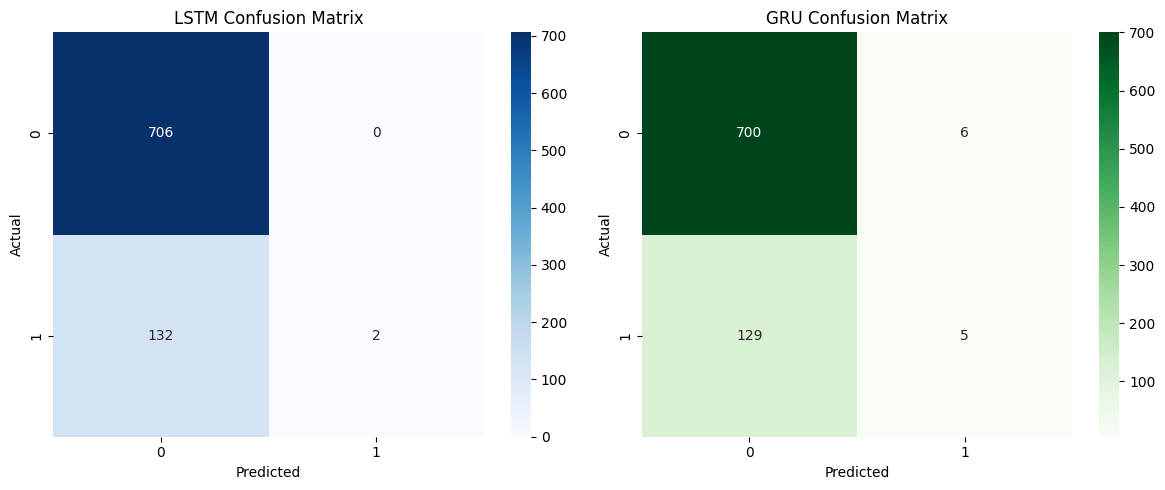

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score

# AUC-ROC Scores
print("AUC-ROC Scores:")
print(f"Logistic Regression: {roc_auc_score(val_df['toxic'], y_pred_proba_lr):.4f}")
print(f"Random Forest: {roc_auc_score(val_df['toxic'], y_pred_proba_rf):.4f}")

# LSTM AUC
lstm_probs = lstm_model.predict(X_val_pad)
print(f"LSTM: {roc_auc_score(val_df['toxic'], lstm_probs):.4f}")

# GRU AUC
gru_probs = gru_model.predict(X_val_pad)
print(f"GRU: {roc_auc_score(val_df['toxic'], gru_probs):.4f}")

# Binary predictions
y_pred_lstm = (lstm_probs >= 0.5).astype(int)
y_pred_gru = (gru_probs >= 0.5).astype(int)

# Confusion Matrices
conf_matrix_lstm = confusion_matrix(val_df['toxic'], y_pred_lstm)
conf_matrix_gru = confusion_matrix(val_df['toxic'], y_pred_gru)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('LSTM Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_matrix_gru, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('GRU Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [43]:
def predict_toxicity(sentence, lr_model, rf_model, lstm_model, gru_model, tokenizer, tfidf):
    cleaned_sentence = clean_text(sentence)

    # Make predictions using the baseline models
    X_sentence_tfidf = tfidf.transform([cleaned_sentence])
    lr_pred = lr_model.predict(X_sentence_tfidf)[0]
    lr_pred_proba = lr_model.predict_proba(X_sentence_tfidf)[0][1]

    rf_pred = rf_model.predict(X_sentence_tfidf)[0]
    rf_pred_proba = rf_model.predict_proba(X_sentence_tfidf)[0][1]

    # Make predictions using the advanced models
    X_sentence_seq = tokenizer.texts_to_sequences([cleaned_sentence])
    X_sentence_pad = pad_sequences(X_sentence_seq, maxlen=100, padding='post')

    lstm_pred = (lstm_model.predict(X_sentence_pad) >= 0.5).astype(int)[0][0]
    lstm_pred_proba = lstm_model.predict(X_sentence_pad)[0][0]

    gru_pred = (gru_model.predict(X_sentence_pad) >= 0.5).astype(int)[0][0]
    gru_pred_proba = gru_model.predict(X_sentence_pad)[0][0]


    # Return the predictions and probabilities
    return {
        "Logistic Regression": {"Prediction": lr_pred, "Probability": lr_pred_proba},
        "Random Forest": {"Prediction": rf_pred, "Probability": rf_pred_proba},
        "LSTM": {"Prediction": lstm_pred, "Probability": lstm_pred_proba},
        "GRU": {"Prediction": gru_pred, "Probability": gru_pred_proba}
    }

# Example usage
input_sentence = "fuck you asshole..freedom of speech bitch"
result = predict_toxicity(input_sentence, lr_model, rf_model, lstm_model, gru_model, tokenizer, tfidf)

# Print the results
print(f"Input Sentence: {input_sentence}\n")
for model_name, prediction in result.items():
    print(f"{model_name}: Prediction = {prediction['Prediction']}, Probability = {prediction['Probability']:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Input Sentence: fuck you asshole..freedom of speech bitch

Logistic Regression: Prediction = 1, Probability = 0.9873
Random Forest: Prediction = 1, Probability = 0.9700
LSTM: Prediction = 1, Probability = 0.8646
GRU: Prediction = 1, Probability = 0.9610
